Reg No: 20MAI0015

GitHub : 

In [3]:
import os, sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing

In [5]:
from sklearn.metrics import r2_score
from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential
from datetime import datetime ,timedelta

# VISUALIZING THE DATASET

In [6]:
#data loading
electricity = pd.read_csv('FE_hourly.csv',index_col=[0], parse_dates=[0])
electricity.head(3)

,FE_MW
Datetime,
2011-12-31 01:00:00,6222.0
2011-12-31 02:00:00,5973.0
2011-12-31 03:00:00,5778.0


In [7]:
#checking missing data
electricity.isna().sum()

FE_MW    0
dtype: int64

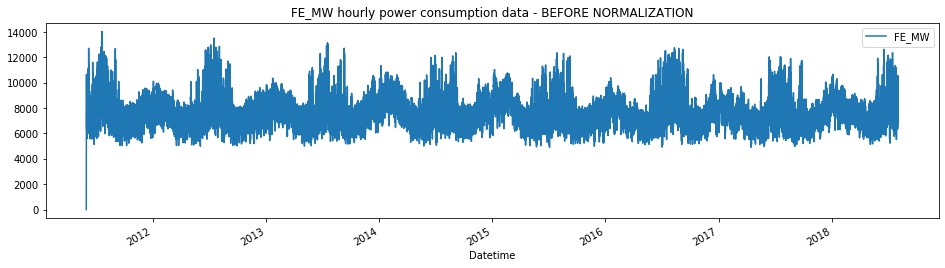

In [8]:
#plotting data
electricity.plot(figsize=(16,4),legend=True)
plt.title('FE_MW hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

In [9]:
def normalize_data(electricity):
    scaler = sklearn.preprocessing.MinMaxScaler()
    electricity['FE_MW']=scaler.fit_transform(electricity['FE_MW'].values.reshape(-1,1))
    return electricity

electricity_norm = normalize_data(electricity)
electricity_norm.shape

(62874, 1)

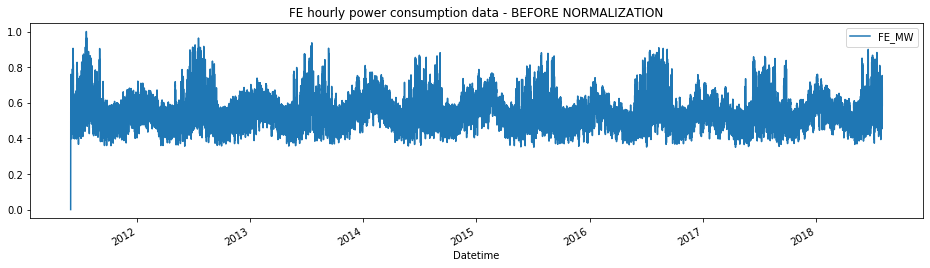

In [10]:
electricity.plot(figsize=(16,4),legend=True)
plt.title('FE hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

In [11]:
electricity_norm.shape

(62874, 1)

In [12]:
#prepare data for preparing rnn models 

def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 874 days are going to be used in test
    X_test = X_train[62000:]             
    y_test = y_train[62000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:62000]           
    y_train = y_train[:62000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (62000, seq_len, 1))    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))    
    
    return [X_train, y_train, X_test, y_test]

In [14]:
#create train, test data
seq_len = 20 #choose sequence length

X_train, y_train, X_test, y_test = load_data(electricity, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (62000, 20, 1)
y_train.shape =  (62000,)
X_test.shape =  (854, 20, 1)
y_test.shape =  (854,)


# RNN MODEL IMPLEMENTATION

In [15]:
#build a simple rnn model 

rnn_model = Sequential()
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))
rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.15))
rnn_model.add(Dense(1))
rnn_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 20, 40)            1680      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 20, 40)            3240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 40)                3240      
_________________________________________________________________
dropout_3 (Dropout)          (None, 40)                0         
________________________________________________

In [16]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=30, batch_size=1000)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
62000/62000 [==============================] - 8s 127us/step - loss: 0.1209
Epoch 2/30
62000/62000 [==============================] - 7s 109us/step - loss: 0.0275
Epoch 3/30
62000/62000 [==============================] - 7s 112us/step - loss: 0.0159
Epoch 4/30
62000/62000 [==============================] - 7s 108us/step - loss: 0.0114
Epoch 5/30
62000/62000 [==============================] - 7s 108us/step - loss: 0.0089
Epoch 6/30
62000/62000 [==============================] - 7s 108us/step - loss: 0.0072
Epoch 7/30
62000/62000 [==============================] - 7s 108us/step - loss: 0.0061
Epoch 8/30
62000/62000 [==============================] - 7s 107us/step - loss: 0.0054
Epoch 9/30
62000/62000 [==============================] - 7s 108us/step - loss: 0.0048
Epoch 10/30
62000/62000 [==============================] - 7s 109us/step - loss: 0.0042
Epoch 11/30
62000/62000 [==============================] - 7s 107us/step - loss: 

In [17]:
rnn_predictions = rnn_model.predict(X_test)
rnn_score = r2_score(y_test,rnn_predictions)
print("R2 Score of RNN model = ",rnn_score)

R2 Score of RNN model =  0.9326665891298384


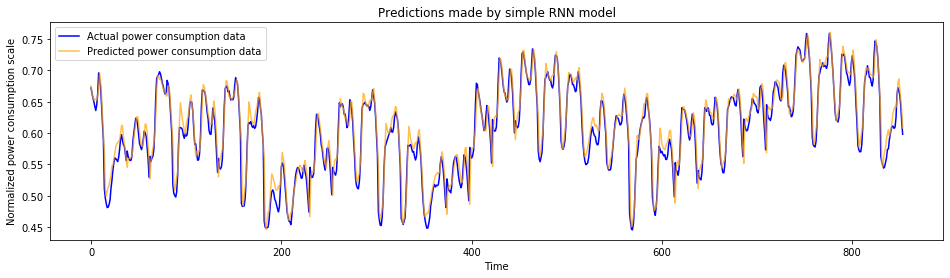

In [18]:
#actual vs predicted 

def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, rnn_predictions, "Predictions made by simple RNN model")

# LTSM MODEL IMPLEMENTATION

In [19]:
#build an lstm model

lstm_model = Sequential()
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))
lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))
lstm_model.add(Dense(1))
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20, 40)            6720      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 40)            12960     
_________________________________________________________________
dropout_5 (Dropout)          (None, 20, 40)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dropout_6 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [20]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train, y_train, epochs=30, batch_size=1000)

Epoch 1/30
62000/62000 [==============================] - 22s 350us/step - loss: 0.0307
Epoch 2/30
62000/62000 [==============================] - 19s 312us/step - loss: 0.0103
Epoch 3/30
62000/62000 [==============================] - 20s 316us/step - loss: 0.0098
Epoch 4/30
62000/62000 [==============================] - 21s 334us/step - loss: 0.0092
Epoch 5/30
62000/62000 [==============================] - 20s 330us/step - loss: 0.0087
Epoch 6/30
62000/62000 [==============================] - 19s 309us/step - loss: 0.0076
Epoch 7/30
62000/62000 [==============================] - 19s 310us/step - loss: 0.0053
Epoch 8/30
62000/62000 [==============================] - 19s 306us/step - loss: 0.0041
Epoch 9/30
62000/62000 [==============================] - 19s 304us/step - loss: 0.0037
Epoch 10/30
62000/62000 [==============================] - 19s 303us/step - loss: 0.0033
Epoch 11/30
62000/62000 [==============================] - 19s 309us/step - loss: 0.0030
Epoch 12/30
62000/62000 [=====

In [21]:
lstm_predictions = lstm_model.predict(X_test)
lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  0.9299672843679988


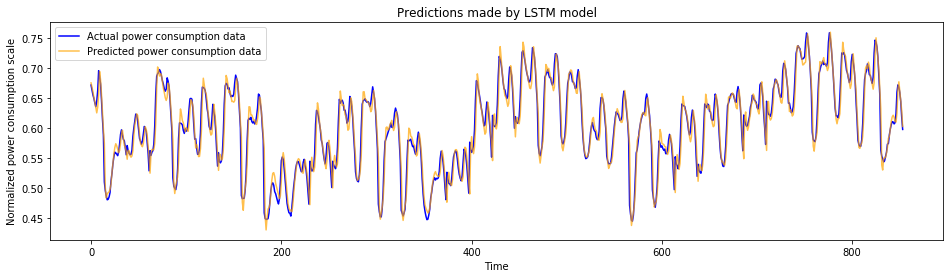

In [22]:
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

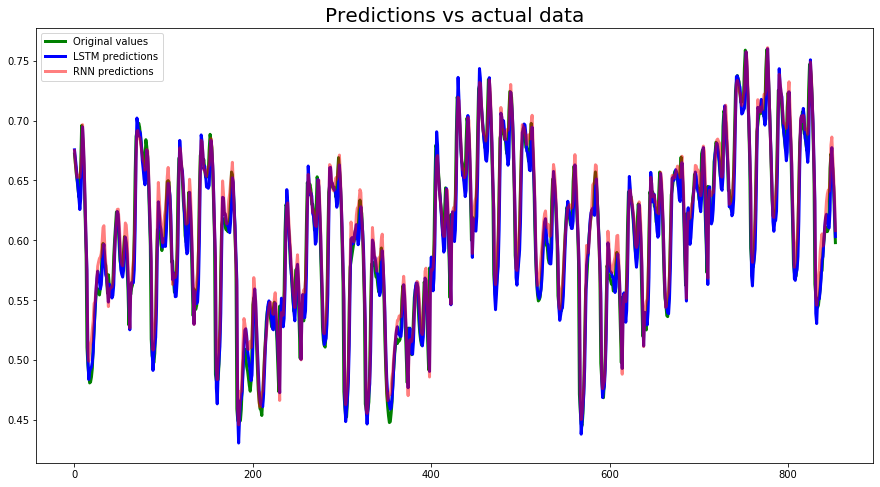

In [28]:
#Compare predictions made by simple RNN, LSTM model by plotting data in a single graph
plt.figure(figsize=(15,8))
plt.plot(y_test, c="green", linewidth=3, label="Original values")
plt.plot(lstm_predictions, c="blue", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="red", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("Predictions vs actual data", fontsize=20)
plt.show()

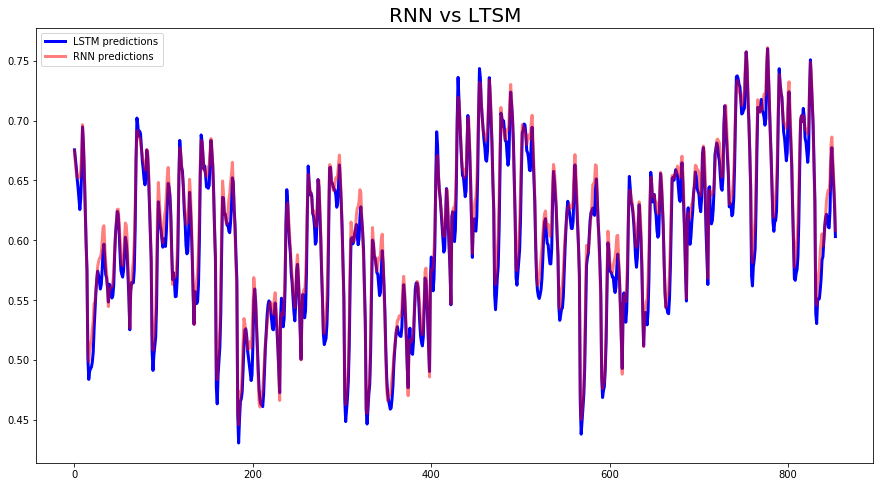

In [27]:
#Compare predictions made by simple RNN, LSTM model by plotting data in a single graph

plt.figure(figsize=(15,8))
plt.plot(lstm_predictions, c="blue", linewidth=3, label="LSTM predictions")
plt.plot(rnn_predictions, alpha=0.5, c="red", linewidth=3, label="RNN predictions")
plt.legend()
plt.title("RNN vs LTSM", fontsize=20)
plt.show()

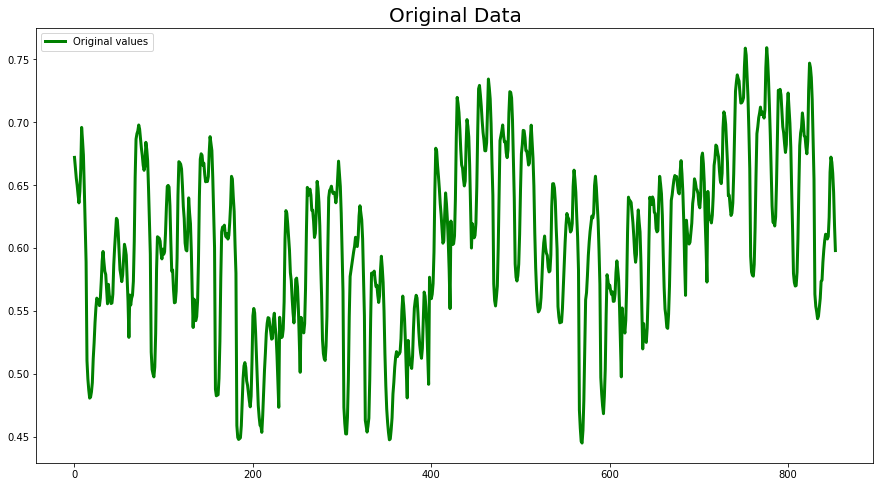

In [29]:
plt.figure(figsize=(15,8))
plt.plot(y_test, c="green", linewidth=3, label="Original values")
plt.legend()
plt.title("Original Data", fontsize=20)
plt.show()